# DQNN Algorithm Tutorial

# Basic Imports

In [33]:
import gymnasium as gym
from tqdm.notebook import trange
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
from collections import deque

## The Environment — Process Model

In [34]:
def take_action(env, action):
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    return state, reward, done

In [115]:
def create_q_network(h1_size=150, h2_size=100):
    return torch.nn.Sequential(
        torch.nn.Linear(4, h1_size),
        torch.nn.ReLU(),
        torch.nn.Linear(h1_size, h2_size),
        torch.nn.ReLU(),
        torch.nn.Linear(h2_size, 2))

In [116]:
def compute_epsilon(epsilon_current, delta_epsilon, epsilon_min):
    epsilon_new = epsilon_current - delta_epsilon
    if epsilon_new < epsilon_min:
        epsilon_new = epsilon_min
    return epsilon_new

In [117]:
def choose_action(model, state, epsilon):
    q_values = model(torch.from_numpy(state).float())
    q_values_ = q_values.data.numpy()
    if random.random() < epsilon:
        action = np.random.randint(0, 2)
    else:
        action = np.argmax(q_values_)
    return action, q_values

In [118]:
def compute_loss(loss_function, model, experience, discounting_factor, minibatch_size):
    if len(experience) >= minibatch_size:
        minibatch = random.sample(experience, minibatch_size)
        # states = torch.cat([s_ for (s_, a_, r_, new_s_, done_) in minibatch])
        states = torch.Tensor(np.vstack([s_ for (s_, a_, r_, new_s_, done_) in minibatch]))
        actions = torch.Tensor([a_ for (s_, a_, r_, new_s_, done_) in minibatch])
        rewards = torch.Tensor([r_ for (s_, a_, r_, new_s_, done_) in minibatch])
        # new_states = torch.cat([new_s_ for (s_, a_, r_, new_s_, done_) in minibatch])
        new_states = torch.Tensor(np.vstack([new_s_ for (s_, a_, r_, new_s_, done_) in minibatch]))
        done = torch.Tensor([done_ for (s_, a_, r_, new_s_, done_) in minibatch])

        q_values = model(states)
        with torch.no_grad():
            new_q_values = model(new_states)

        max_q_value = torch.max(new_q_values, dim=1)[0]
        target = (rewards + discounting_factor * (1 - done) * max_q_value).reshape(minibatch_size)
        predict = q_values.gather(dim=1, index=actions.long().unsqueeze(dim=1)).squeeze().reshape(minibatch_size)
        return loss_function(predict, target.detach())

In [119]:
def create_loss_and_optimizer(model, learning_rate):
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    return loss_function, optimizer

In [120]:
def update_weights(optimizer, loss_value):
    optimizer.zero_grad()
    loss_value.backward()
    optimizer.step()

In [121]:
q_network = create_q_network()

env = gym.make("CartPole-v1")

In [122]:
gamma = 0.9
eps = 1.0

epochs = 2000
max_actions_per_game = 500
experience_size = 1000
batch_size = 200

exp = deque(maxlen=experience_size)

loss_fn, qnn_optimizer = create_loss_and_optimizer(q_network, 1e-3)
scores = []
for i in (pbar := trange(epochs)):

    s, _ = env.reset()

    actions_taken = 0
    total_loss = 0
    while True:
        actions_taken += 1
        a, q = choose_action(q_network, s, eps)
        new_s, r, terminate = take_action(env, a)

        terminate = terminate or \
                    (actions_taken == max_actions_per_game)

        exp.append((s, a, r, new_s, terminate))
        loss = compute_loss(loss_fn, q_network, exp, gamma, batch_size)
        if loss is not None:
            update_weights(qnn_optimizer, loss)
            total_loss += loss.item()
        
        s = new_s

        if terminate:
            pbar.set_postfix_str(f"actions_taken={actions_taken}", refresh=False)
            scores.append(actions_taken)
            break

    eps = compute_epsilon(eps, delta_epsilon=1 / epochs, epsilon_min=0.01)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [129]:
epochs = 1000
eps = 0.2

scores = []
for i in (pbar := trange(epochs)):

    s, _ = env.reset()

    actions_taken = 0
    total_loss = 0
    while True:
        actions_taken += 1
        a, q = choose_action(q_network, s, eps)
        new_s, r, terminate = take_action(env, a)

        terminate = terminate or \
                    (actions_taken == max_actions_per_game)

        exp.append((s, a, r, new_s, terminate))
        loss = compute_loss(loss_fn, q_network, exp, gamma, batch_size)
        if loss is not None:
            update_weights(qnn_optimizer, loss)
            total_loss += loss.item()
        
        s = new_s

        if terminate:
            pbar.set_postfix_str(f"actions_taken={actions_taken}", refresh=False)
            scores.append(actions_taken)
            break

    eps = compute_epsilon(eps, delta_epsilon=1 / epochs, epsilon_min=0.01)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [130]:
def filter_timeseries(ts, p):
    tsf = np.nan * np.ones_like(ts)
    prev = ts[0]
    for i, v in enumerate(ts):
        tsf[i] = prev = p * prev + (1-p) * v
    return tsf

In [131]:
def visualize_scores(scores):
    scores = np.array(scores)
    filtered = filter_timeseries(scores, 0.95)
    data = np.zeros((len(scores), 2))
    data[:,0] = scores
    data[:,1] = filtered
    plt.plot(data)

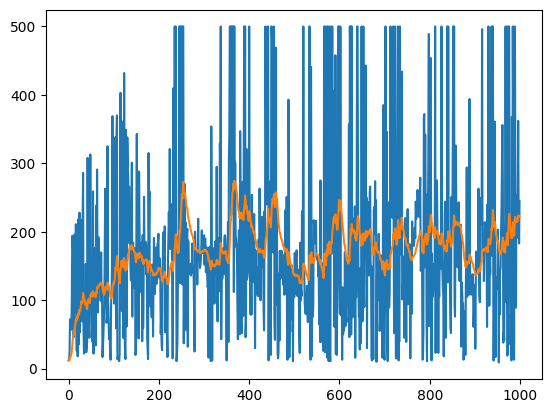

In [132]:
visualize_scores(scores)

In [133]:
test_epochs = 200
test_duration = 500
test_scores = []
for i in (pbar := trange(test_epochs)):

    s, _ = env.reset()

    actions_taken = 0
    total_loss = 0
    while True:
        actions_taken += 1
        a, q = choose_action(q_network, s, 0.0)
        s, r, terminate = take_action(env, a)

        terminate = terminate or \
                    (actions_taken == test_duration)

        if terminate:
            pbar.set_postfix_str(f"actions_taken={actions_taken}", refresh=False)
            test_scores.append(actions_taken)
            break

  0%|          | 0/200 [00:00<?, ?it/s]

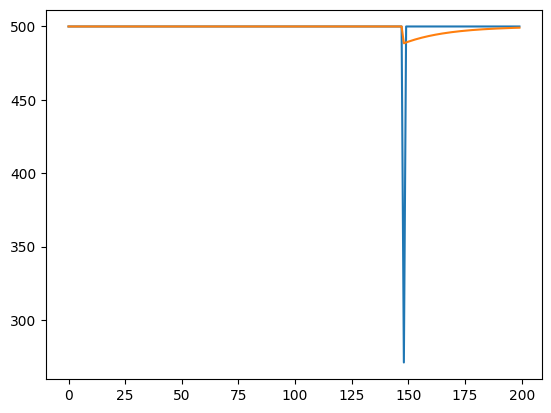

In [134]:
visualize_scores(test_scores)

In [89]:
discounting_factor

NameError: name 'discounting_factor' is not defined